In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
file_path = 'updated_data.csv'  # Update this to your actual file path
data = pd.read_csv(file_path)

# Data preprocessing
data['timeStamp'] = pd.to_datetime(data['timeStamp'], format='%H:%M:%S').dt.hour  # Convert timeStamp into hour of the day
data['dateStamp'] = pd.to_datetime(data['dateStamp']).dt.day  # Convert dateStamp to day of the month
data.drop(columns=['weatherStamp:'], inplace=True)  # Dropping the weatherStamp column

# Creating a DataFrame to store the latest 'num_cars' values for each trafficID, excluding the current one
latest_num_cars_data = []
traffic_ids = data['trafficID'].unique()

# Iterate over each unique timestamp to get the latest 'num_cars' for other traffic lights
for (day, hour), group in data.groupby(['dateStamp', 'timeStamp']):
    for traffic_id in traffic_ids:
        filtered_group = group[group['trafficID'] != traffic_id]
        if not filtered_group.empty:
            latest_value = filtered_group['num_cars'].iloc[-1]  # Get the last 'num_cars' value
            latest_num_cars_data.append({
                'dateStamp': day,
                'timeStamp': hour,
                f'latest_num_cars_excl_{traffic_id}': latest_value,
                'trafficID': traffic_id
            })

# Convert list of dictionaries to DataFrame
latest_num_cars_df = pd.DataFrame(latest_num_cars_data)

# Merge the latest_num_cars_data with the original data
data = pd.merge(data, latest_num_cars_df, on=['dateStamp', 'timeStamp', 'trafficID'], how='left')

# Drop the original 'num_cars' column to prevent data leakage
data.drop(columns=['num_cars'], inplace=True)

# Fill any remaining NaNs with the median of the column for numeric columns only
median_values = data.select_dtypes(include=['number']).median()
data.fillna(median_values, inplace=True)

# One-hot encode the 'trafficID' column
encoder = OneHotEncoder(sparse=False)
trafficID_encoded = encoder.fit_transform(data[['trafficID']])
trafficID_encoded_df = pd.DataFrame(trafficID_encoded, columns=encoder.get_feature_names_out())

# Merge the encoded DataFrame back to the main DataFrame
data_prepared = pd.concat([data.drop(columns=['trafficID']), trafficID_encoded_df], axis=1)

# Split data into features and target
X = data_prepared.drop(columns=['greenTime'])
y = data_prepared['greenTime']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_gb = gb_model.predict(X_test)

# Initialize and train the XGBoost model with reduced complexity
xgb_model = XGBRegressor(n_estimators=50, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Calculate performance metrics for all models
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("Random Forest MSE:", mse_rf, "R2:", r2_rf)
print("Gradient Boosting MSE:", mse_gb, "R2:", r2_gb)
print("XGBoost MSE:", mse_xgb, "R2:", r2_xgb)


c:\Users\trh00\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Random Forest MSE: 231.54930155279504 R2: 0.058630147432580326
Gradient Boosting MSE: 222.46969952767319 R2: 0.09554351129263483
XGBoost MSE: 218.93245901415298 R2: 0.10992425681152718


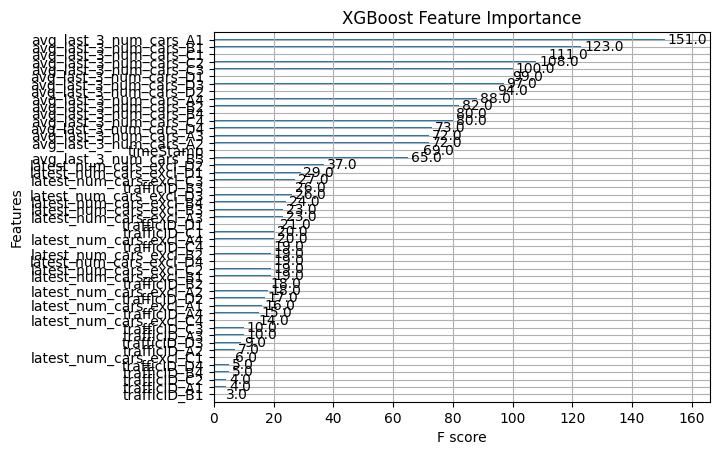

In [26]:
import matplotlib.pyplot as plt
import xgboost as xgb
xgb.plot_importance(xgb_model)
plt.title("XGBoost Feature Importance")

plt.show()

In [18]:

# Load the dataset
data = pd.read_csv('dataset2.csv')

# Function to calculate the rolling average for the last 3 values with duplication if less than 3 are available
def rolling_avg(series):
    # If the series is shorter than 3, extend it by repeating the last value
    if len(series) < 3:
        series = pd.Series([series.iloc[-1]] * (3 - len(series))).append(series)
    return series.rolling(3, min_periods=1).mean()

# Identify all unique traffic lights in the dataset
all_traffic_lights = data['trafficID'].unique()

# Process each unique traffic light to create a new column for the rolling average of num_cars
for light in all_traffic_lights:
    column_name = f'avg_last_3_num_cars_{light}'
    if column_name not in data.columns:
        data[column_name] = data[data['trafficID'] == light]['num_cars'].transform(rolling_avg)

# Save the modified dataset to a new CSV file
# data.to_csv('/path/to/your/modified_dataset.csv', index=False)
data

,trafficID,num_cars,weatherStamp:,timeStamp,dateStamp,greenTime,avg_last_3_num_cars_A1,avg_last_3_num_cars_B1,avg_last_3_num_cars_C1,avg_last_3_num_cars_D1,...,avg_last_3_num_cars_C3,avg_last_3_num_cars_D3,avg_last_3_num_cars_A2,avg_last_3_num_cars_D4,avg_last_3_num_cars_A3,avg_last_3_num_cars_C4,avg_last_3_num_cars_A4,avg_last_3_num_cars_B2,avg_last_3_num_cars_B3,avg_last_3_num_cars_B4
0,A1,47,33,04:16:14,2024-08-01,24,47.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,B1,96,33,04:16:14,2024-08-01,48,NaN,96.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C1,0,33,04:16:14,2024-08-01,3,NaN,NaN,0.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D1,0,33,04:16:14,2024-08-01,3,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C2,5,33,04:16:19,2024-08-01,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8045,C4,67,33,00:01:48,2024-08-02,34,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,45.333333,NaN,NaN,NaN,NaN
8046,B1,22,33,00:02:03,2024-08-02,16,NaN,67.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8047,D3,89,33,00:02:06,2024-08-02,45,NaN,NaN,NaN,NaN,...,NaN,57.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8048,B2,111,33,00:02:21,2024-08-02,50,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.333333,NaN,NaN


In [21]:

def latest3forID(id, data, index):
    # Slice the data from the start up to the current index (not including the current row)
    data_up_to_index = data[:index]
    # Get the last 3 values of the num_cars for the given trafficID
    latest3 = data_up_to_index[data_up_to_index['trafficID'] == id]['num_cars'].tail(3)
    # If there are less than 3 values, fill the rest with the mean of the available values (or replicate the last value if no values are available)
    if len(latest3) < 3:
        fill_value = latest3.mean() if not latest3.empty else 0  # Use 0 or some default if no values are available
        # Use concat to append the necessary number of fill_values to the latest3 series
        latest3 = pd.concat([latest3, pd.Series([fill_value] * (3 - len(latest3)))])
    return latest3.mean()


In [22]:
import pandas as pd

# Load the dataset
# Example: data = pd.read_csv('your_data.csv')

# Initialize a new column for each unique traffic light ID in the DataFrame
unique_ids = data['trafficID'].unique()
for uid in unique_ids:
    data[f'avg_last_3_num_cars_{uid}'] = 0  # Initialize the column for each unique ID

# Iterate over the DataFrame and update each traffic light's average
for index, row in data.iterrows():
    for uid in unique_ids:
        # Update the column for the specific traffic light ID
        data.at[index, f'avg_last_3_num_cars_{uid}'] = latest3forID(uid, data, index)

# Save the updated data to a new CSV file
data.to_csv('updated_data.csv', index=False)


C:\Users\trh00\AppData\Local\Temp\ipykernel_35844\187540784.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '37.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[index, f'avg_last_3_num_cars_{uid}'] = latest3forID(uid, data, index)
C:\Users\trh00\AppData\Local\Temp\ipykernel_35844\187540784.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '18.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.at[index, f'avg_last_3_num_cars_{uid}'] = latest3forID(uid, data, index)
C:\Users\trh00\AppData\Local\Temp\ipykernel_35844\187540784.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '72.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data